In [1]:
from osgeo import osr, ogr, gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import geopandas as gpd
import rasterio
from sklearn.model_selection import train_test_split
import geopandas as gpd
from rasterio.plot import show
from geohelpers import collocate, getCoords
from osgeo import osr, ogr, gdal
import pyproj
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import math
import datetime
import geopandas as gpd
import warnings
from sklearn.preprocessing import QuantileTransformer
warnings. filterwarnings('ignore')

goal: produce a 30m raster where each pixel is binned by some index (using a dummy rn) Use SVR (support vector regression) for continuous multi-class classification.

In [6]:
td = r"RawRasters\Train_416.shp"
scaler = QuantileTransformer(output_distribution='uniform')

td_gdf = gpd.read_file(td)

td_gdf['NightLight'] = scaler.fit_transform(td_gdf['NightLight'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['TransitWei'] = scaler.fit_transform(td_gdf['transit1'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['IncomeWeig'] = scaler.fit_transform(td_gdf['income'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['RaceWeigh'] = scaler.fit_transform(td_gdf['race'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['EucDist_pa'] = 100- scaler.fit_transform(td_gdf['EucDist_pa'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['StlPop_30m'] = scaler.fit_transform(td_gdf['StlPop_30m'].values.reshape(-1, 1)).reshape(-1)*100


td_gdf = td_gdf.drop(columns=['CID'])
td_gdf = td_gdf.drop(columns='geometry')
td_gdf.head()


OBJECTID  transit1      race    income  StlPop_30m  NightLight  EucDist_pa  \
0         1  0.011853  0.011104  0.009674   43.286573   68.236473   78.857715   
1         2  0.017765  0.011035  0.009694    0.000000   26.152305   21.042084   
2         3  0.021888  0.009415  0.009679    0.000000    0.000000   16.733467   
3         4  0.001672  0.007478  0.009471    0.000000   46.492986   31.863727   
4         5  0.002610  0.007746  0.009604   98.797595   65.130261   46.092184   

   CID_bin_fm  NRSA_bin  TDD_lin_Cl  SBDs_bin_f  TransitWei  IncomeWeig  \
0           0         1           0           0   65.831663   82.464930   
1           0         0           0           0   75.851703   97.995992   
2           0         0           0           0   84.869739   88.877756   
3           0         0           0           0   14.128257    2.505010   
4           0         1           0           0   24.448898   37.074148   

   RaceWeigh  
0  63.026052  
1  60.220441  
2  51.503006  
3  21.342685  
4  24.448898

In [7]:
td_df = pd.DataFrame(td_gdf)

In [9]:
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler

# List of raster file paths
raster_files = [
    r"RawRasters\NightLightsStl.tif",
    r"RawRasters\dist2park.tif",
    r"RawRasters\StlPop.tif",
    r"RawRasters\transit.tif",
    r"RawRasters\race.tif",
    r"RawRasters\income.tif",
]
ras_ds = gdal.Open(r"RawRasters\dist2park.tif")

arrays = []

# Loop through each raster file and read it as an array
for file_path in raster_files:
    with rasterio.open(file_path, dtype='float32') as src:
        arr = src.read(1)  # Assuming you want to read the first band (index 0)
        raster_extent = src.bounds
        if "StlPop" in file_path:
            arr[np.isnan(arr)] = 0
        arrays.append(arr*100)

# Concatenate the arrays along the third axis (axis=2) to create an nxmx10 array
feature_mat = np.stack(arrays, axis=2)
m,n,h = feature_mat.shape

In [10]:
# Normalize the data to a 0-1 scale using QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')

nl = feature_mat[:,:,0] 
nlnorm = scaler.fit_transform(nl.reshape(-1, 1)).reshape(-1)*100
nlnorm = nlnorm.reshape(m,n)

d2p = feature_mat[:,:,1] 
d2pnorm = 100-scaler.fit_transform(d2p.reshape(-1, 1)).reshape(-1)*100
d2pnorm = d2pnorm.reshape(m,n)

pop = feature_mat[:,:,2] 
popnorm = scaler.fit_transform(pop.reshape(-1, 1)).reshape(-1)*100
popnorm = popnorm.reshape(m,n)

trans = feature_mat[:,:,3] 
transnorm = scaler.fit_transform(trans.reshape(-1, 1)).reshape(-1)*100
transnorm = transnorm.reshape(m,n)

inc = feature_mat[:,:,5] 
incnorm = scaler.fit_transform(inc.reshape(-1, 1)).reshape(-1)*100
incnorm = incnorm.reshape(m,n)

race = feature_mat[:,:,4] 
racenorm = scaler.fit_transform(race.reshape(-1, 1)).reshape(-1)*100
racenorm = racenorm.reshape(m,n)
       
feature_mat[:, :, 0] = nlnorm
feature_mat[:, :, 1] = d2pnorm
feature_mat[:, :, 2] = popnorm
feature_mat[:, :, 3] = transnorm
feature_mat[:, :, 4] = racenorm
feature_mat[:, :, 5] = incnorm

#calculate index 

print("Shape of the modified array:", feature_mat.shape)
print("Data type of the modified array:", feature_mat.dtype)
print("Mean value of the modified array:", np.mean(feature_mat))

Shape of the modified array: (320, 159, 6)
Data type of the modified array: float64
Mean value of the modified array: nan


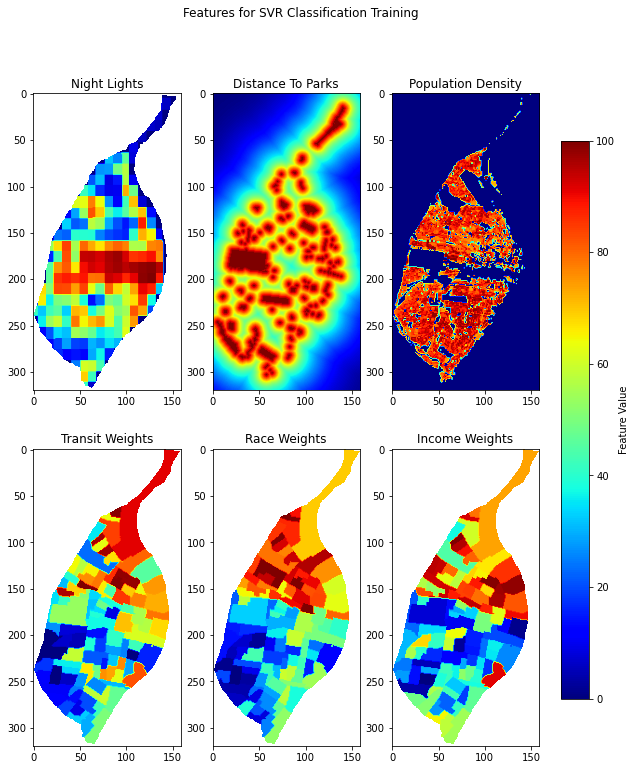

In [13]:
# Plot Classified Image 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,12))
ax0, ax1, ax2, ax3, ax4, ax5 = ax.flatten()
#ax0, ax1, ax2, = ax.flatten()

axArr = ax.flatten()
ax_index = 0
names = ['Night Lights','Distance To Parks','Population Density','Transit Weights','Race Weights','Income Weights']
#names = ['Transit Weights','Race Weights','Income Weights']

for i in range(6):
    img = axArr[ax_index].imshow(feature_mat[:, :, i], cmap='jet')
    axArr[ax_index].set_title(names[i])
    ax_index += 1
cbar = fig.colorbar(img, ax=axArr, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label('Feature Value')  

fig.suptitle('Features for SVR Classification Training')
plt.savefig('outputs\InputFeaturesSVR.png')
#plt.savefig('outputs\Weights.png')
plt.show()


In [14]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [15]:
td_df = gpd.GeoDataFrame(td_gdf)
td_df.head()

OBJECTID  transit1      race    income  StlPop_30m  NightLight  EucDist_pa  \
0         1  0.011853  0.011104  0.009674   43.286573   68.236473   78.857715   
1         2  0.017765  0.011035  0.009694    0.000000   26.152305   21.042084   
2         3  0.021888  0.009415  0.009679    0.000000    0.000000   16.733467   
3         4  0.001672  0.007478  0.009471    0.000000   46.492986   31.863727   
4         5  0.002610  0.007746  0.009604   98.797595   65.130261   46.092184   

   CID_bin_fm  NRSA_bin  TDD_lin_Cl  SBDs_bin_f  TransitWei  IncomeWeig  \
0           0         1           0           0   65.831663   82.464930   
1           0         0           0           0   75.851703   97.995992   
2           0         0           0           0   84.869739   88.877756   
3           0         0           0           0   14.128257    2.505010   
4           0         1           0           0   24.448898   37.074148   

   RaceWeigh  
0  63.026052  
1  60.220441  
2  51.503006  
3  21.342685  
4  24.448898

In [19]:
# calculate class labels (index)

# Extract the specified columns from td_df
selected_columns = ['IncomeWeig', 'RaceWeigh', 'TransitWei']
# Add the values of 'IncomeWeigh', 'RaceWeigh', and 'TransitWei' element-wise
sum_row = td_df[['CID_bin_fm', 'NRSA_bin', 'TDD_lin_Cl','SBDs_bin_f']].sum(axis=1)
# Append the sum row to td_df
td_df['Labels'] = sum_row.values
td_df = td_df.drop(columns = ['CID_bin_fm', 'NRSA_bin', 'TDD_lin_Cl','SBDs_bin_f'])

#td_df['Labels'] = np.ones(500)
#td_df = td_df.drop(columns = 'CZID')
# Reset the index to ensure it's continuous
td_df.reset_index(drop=True, inplace=True)

td_df.head()

OBJECTID  transit1  race   income  StlPop_30m  NightLight  EucDist_pa  TransitWei  IncomeWeig  RaceWeigh  Labels
0      1       0.012   0.011   0.010    43.287      68.236      78.858      65.832      82.465     63.026       1  
1      2       0.018   0.011   0.010     0.000      26.152      21.042      75.852      97.996     60.220       0  
2      3       0.022   0.009   0.010     0.000       0.000      16.733      84.870      88.878     51.503       0  
3      4       0.002   0.007   0.009     0.000      46.493      31.864      14.128       2.505     21.343       0  
4      5       0.003   0.008   0.010    98.798      65.130      46.092      24.449      37.074     24.449       1

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [21]:
# Assuming td_df is your DataFrame and 'StlPop_fm' is a column name
n_samples, n_features = td_df.shape[0], td_df.shape[1]-2
start = td_df.columns.get_loc('StlPop_30m')
X = td_df.iloc[:, start:-1]

y = td_df.iloc[:,-1]  # Class labels
display(X)
display(y)


StlPop_30m  NightLight  EucDist_pa  TransitWei  IncomeWeig  RaceWeigh
0       43.287      68.236      78.858      65.832      82.465     63.026 
1        0.000      26.152      21.042      75.852      97.996     60.220 
2        0.000       0.000      16.733      84.870      88.878     51.503 
3        0.000      46.493      31.864      14.128       2.505     21.343 
4       98.798      65.130      46.092      24.449      37.074     24.449 
5        0.000      76.052      53.006      72.645      80.962     62.124 
6       82.966      33.066      70.741      68.838      52.906     79.459 
7       57.916      16.633      82.365      15.331      51.503     36.874 
8       52.705      73.948      66.834      43.988      33.667     20.641 
9       89.579      35.070      22.846      99.098      65.531     85.872 
10      68.938      52.004      13.727      65.431      79.659    100.000 
11      99.198      60.421      63.627      73.747      46.593     56.012 
12       0.000      92.585     100.000      45.291      85.671    100.000 
13       0.000      23.747     100.000      17.936      10.220     15.631 
14      72.545      70.741      63.627      27.455      59.519     22.345 
15     100.000      39.178      10.721      19.940      42.685     76.353 
16      46.894      89.178      38.176      43.988      33.667     20.641 
17       0.000      62.024      38.176      48.798      44.990     35.271 
18      56.513      50.401      16.733      30.361      17.635     33.768 
19      87.575      36.373      33.166      49.900      34.068     28.056 
20       0.000      67.535     100.000      54.509       5.812     29.860 
21       0.000       0.000      23.647      34.469      34.770     83.567 
22       0.000      70.741      28.257      27.455      59.519     22.345 
23      96.192      13.026      63.627      17.936      10.220     15.631 
24       0.000      46.894       2.204      93.086      73.948     67.735 
25       0.000       0.000       0.601      93.086      73.948     67.735 
26      97.595      27.154      46.092      34.469      34.770     83.567 
27       0.000      93.788      90.281      54.509       5.812     29.860 
28      67.335      52.004      25.451      58.517      91.483    100.000 
29      58.116       0.000      70.741      29.359      57.916     71.944 
30      79.158      35.571      50.301      13.427      23.046      1.002 
31       0.000      39.980     100.000      82.665      67.335     94.890 
32      56.713      26.653      59.018      66.733      80.060     92.485 
33       0.000      73.647      82.365      93.086      73.948     67.735 
34       0.000      13.026     100.000      17.936      10.220     15.631 
35       0.000      14.830      39.679      48.798      44.990     35.271 
36      88.176      35.972      36.573      51.703      55.010     49.399 
37       0.000      14.429      61.122      86.273      61.623     85.070 
38      59.519      58.617      66.834      51.703      55.010     49.399 
39       0.000      91.082      33.166      70.842      49.499     53.307 
40       0.000      78.758      50.301      10.822      64.128     32.465 
41       0.000      71.743      30.261      82.665      67.335     94.890 
42      56.313      86.573      46.092      46.693      84.168     73.246 
43      71.543      25.651      30.261      64.228      89.880    100.000 
44      61.323      10.020      16.232      97.996      87.074     74.749 
45       0.000      74.850       6.212      84.870      88.878     51.503 
46       0.000      94.489      26.954      70.842      49.499     53.307 
47      98.597      93.788      82.365      29.659      12.024     19.639 
48       0.000      62.024      36.573      48.798      44.990     35.271 
49       0.000      56.713      66.834      93.086      73.948     67.735 
50       0.000      87.575      42.886       6.313      31.663     14.028 
51      92.786      31.663      66.834      21.643      57.315     20.040 
52       0.000      98.497    

0      1
1      0
2      0
3      0
4      1
5      0
6      0
7      0
8      0
9      0
10     1
11     1
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     1
22     0
23     0
24     0
25     0
26     1
27     0
28     1
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     1
44     0
45     0
46     1
47     1
48     0
49     1
50     0
51     0
52     1
53     0
54     0
55     0
56     0
57     0
58     0
59     1
60     1
61     0
62     1
63     0
64     0
65     0
66     0
67     0
68     1
69     0
70     2
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     1
79     1
80     0
81     1
82     0
83     1
84     0
85     0
86     0
87     0
88     0
89     0
90     1
91     0
92     1
93     0
94     0
95     0
96     0
97     1
98     0
99     0
100    0
101    0
102    1
103    0
104    0
105    0
106    0
107    0
108    1
109    0
110    0
1

In [22]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr = SVR()

# Define the grid of hyperparameters to search
param_grid = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-12,1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
    "epsilon":[0.001, 0.01, 0.1, 0.2, 0.3]
    }

# Initialize GridSearchCV with the SVR regressor and hyperparameter grid
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=10)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set using mean squared error (MSE)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(y_pred)

print("Best hyperparameters:", best_params)
print("Mean Squared Error on test set:", mse)


[ 8.82540245e-02  2.39960775e-01  1.15361709e-02  3.93079202e-01
  2.37116008e-01  7.16508761e-02  1.61186132e-01  6.45205371e-01
  5.62084362e-01  1.18231316e-01  6.51826555e-01  1.50968740e-02
  1.86810668e-01  3.00048691e-02  1.50630352e-01  1.09828569e+00
  5.85405762e-01 -6.62693847e-02  6.83941772e-01  9.36483066e-01
  2.00272543e-01  4.78802592e-01  8.02638004e-01  2.42926395e-01
  8.52709084e-02  2.42174359e-01  2.63209002e-02 -1.18942563e-01
  9.34422757e-01 -3.94730491e-02  3.82076547e-01  2.26745079e-01
  6.46869521e-01  1.39473005e-01  8.27837491e-02  4.23208767e-01
  9.98998338e-02  4.93658424e-01  7.76583791e-01  1.31283706e-01
  1.56360202e-01  1.74981207e-01 -3.02709982e-02  8.64717435e-01
  3.03454419e-01  1.00737915e-01  9.42739723e-01  7.27406016e-01
 -1.05113597e-03  6.33810845e-01 -7.53269156e-02  1.61710943e-01
  2.40249983e-02  4.62472974e-01  6.45687270e-01  1.13431564e-01
  1.11874190e-01  2.42643081e-01 -3.58534943e-02  3.91593068e-01
  2.76639148e-01  1.38859

In [23]:
regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1, gamma = 1e-3, kernel = 'rbf'))
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1, gamma=0.001))])

Text(0.5, 0, 'Feature-wise Permutation Importance')

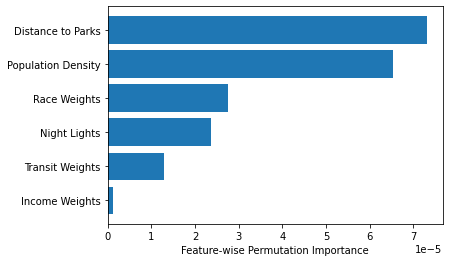

In [24]:
# perform permutation importance
from sklearn.inspection import permutation_importance

importance = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')

feature_names = ['Population Density', 'Night Lights', 'Transit Weights','Income Weights','Race Weights','Distance to Parks']
features = np.array(feature_names)

sorted_idx = importance.importances_mean.argsort()
plt.barh(features[sorted_idx], importance.importances_mean[sorted_idx])
plt.xlabel("Feature-wise Permutation Importance")

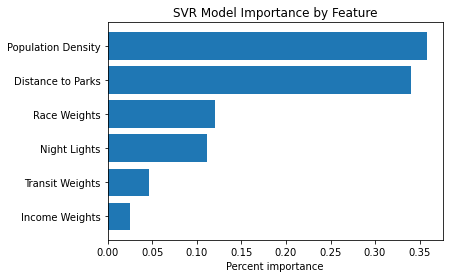

In [25]:
importance = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')

feature_names = ['Population Density', 'Night Lights', 'Transit Weights','Income Weights','Race Weights','Distance to Parks']
features = np.array(feature_names)

sorted_idx = importance.importances_mean.argsort()
normalized_importances = importance.importances_mean[sorted_idx] / np.sum(importance.importances_mean[sorted_idx])  # Normalizing

plt.barh(features[sorted_idx], normalized_importances)
plt.xlabel("Percent importance")
plt.title('SVR Model Importance by Feature')
plt.savefig('outputs\ImportanceSVR.png')
plt.show()

In [26]:
m,n, h = feature_mat.shape
print('m: ',m,'n: ',n,'h: ',h)

m:  320 n:  159 h:  6


In [27]:
feature_mat_flat = feature_mat.reshape(m*n,h)
featdf = pd.DataFrame(feature_mat_flat)
#display(featdf)

In [28]:
import time
import numpy as np

start_time = time.time()  # Start timing

# Define batch size
batch_size = 100

print(feature_mat_flat.shape)
i = 0
assignments = []

for pix in feature_mat_flat:
  #  print(pix)
    if np.isnan(pix).any():  # Check if any NaN values are present
        pred = -1
    else:
        pred = regr.predict(pix.reshape(1, -1))
    
    assignments.append(pred)

    if i % 1000 == 0:
        # print(pix)
        print('pix:', i, 'prediction:', pred)
    
    i += 1
    
# End timing
end_time = time.time()
execution_time = end_time - start_time


(50880, 6)
pix: 0 prediction: -1
pix: 1000 prediction: -1
pix: 2000 prediction: -1
pix: 3000 prediction: [0.10033971]
pix: 4000 prediction: -1
pix: 5000 prediction: -1
pix: 6000 prediction: -1
pix: 7000 prediction: -1
pix: 8000 prediction: -1
pix: 9000 prediction: -1
pix: 10000 prediction: -1
pix: 11000 prediction: -1
pix: 12000 prediction: [0.09979361]
pix: 13000 prediction: -1
pix: 14000 prediction: -1
pix: 15000 prediction: -1
pix: 16000 prediction: [0.10099133]
pix: 17000 prediction: -1
pix: 18000 prediction: -1
pix: 19000 prediction: [0.10085028]
pix: 20000 prediction: [0.10083072]
pix: 21000 prediction: -1
pix: 22000 prediction: [0.10016166]
pix: 23000 prediction: [0.10086039]
pix: 24000 prediction: -1
pix: 25000 prediction: [0.10019647]
pix: 26000 prediction: [0.10174608]
pix: 27000 prediction: [0.10024399]
pix: 28000 prediction: -1
pix: 29000 prediction: [0.10055682]
pix: 30000 prediction: [0.10065974]
pix: 31000 prediction: -1
pix: 32000 prediction: [0.10104917]
pix: 33000 pre

In [29]:
print(f"Execution time: {execution_time} seconds")

Execution time: 10.295765161514282 seconds


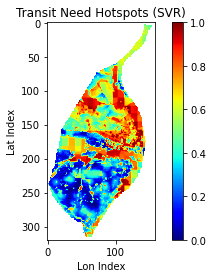

In [46]:
assignments_fixed = []

# Iterate through the predictions
for pred in assignments:
    if isinstance(pred, list):  # Check if pred is a list or array
        assignments_fixed.extend(pred)  # Unpack the list and append its elements
    elif pred == -1:
        assignments_fixed.append(np.nan)  # Replace -1 with NaN
    else:
        assignments_fixed.append(pred)  # Keep the value unchanged

assignmentsArr = np.array(assignments_fixed, dtype='object')
lc = assignmentsArr.reshape(m, n)
 
lcn = scaler.fit_transform(lc.reshape(-1, 1)).reshape(-1)
lcn = lcn.reshape(m,n)

#normalize classified image 
lc_float = lcn.astype(float)
img_class = plt.imshow(lc_float, cmap='jet')
plt.title('Transit Need Hotspots (SVR)')
plt.xlabel('Lon Index')
plt.ylabel('Lat Index')
plt.colorbar(img_class)
plt.savefig('outputs\ClassifiedSVR.png')
plt.show()

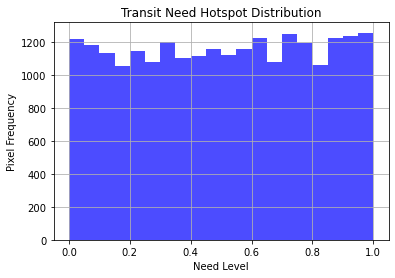

In [31]:
# Flatten the 2D array lc to a 1D array
lc_flattened = lcn.flatten()
# Plot histogram
plt.hist(lc_flattened, bins=20, color='blue', alpha=0.7)
plt.title('Transit Need Hotspot Distribution')
plt.xlabel('Need Level')
plt.ylabel('Pixel Frequency')
plt.grid(True)
plt.savefig('outputs\ClassesHist.png')
plt.show()

Mask out all values that are less than 0.8 to identify areas of most need.

In [40]:
need = lcn>0.8
mask = np.copy(lcn)
mask[~need] = np.nan
mask = mask.reshape(m,n)

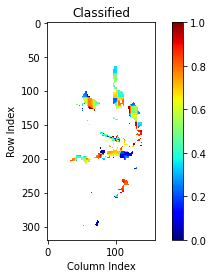

In [41]:
needPlot = plt.imshow(mask, cmap='jet')
plt.title('Classified')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar(img_class)
plt.show()

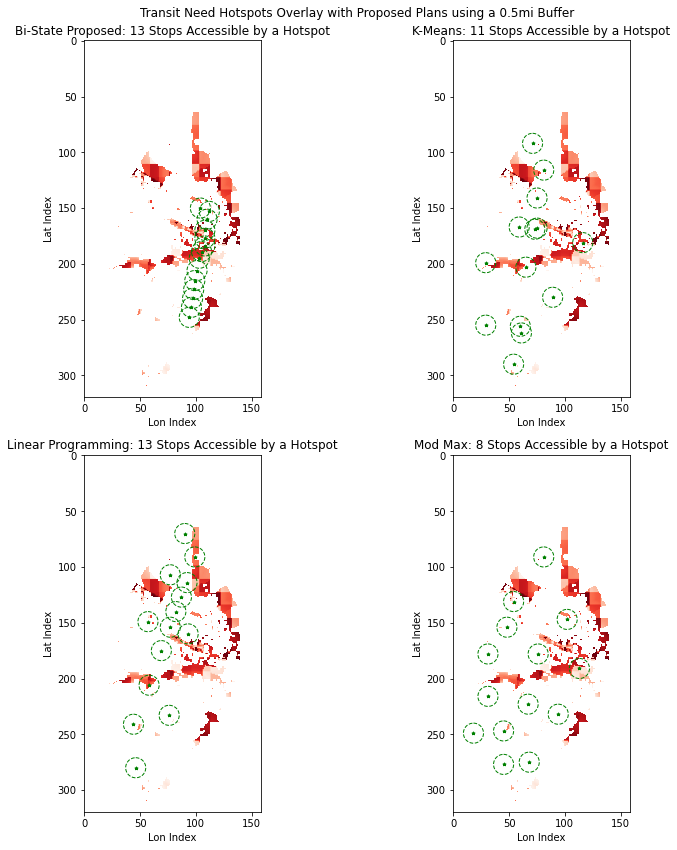

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from matplotlib.patches import Circle

shapefile_paths = [r"plans\OrigStops.shp",r"plans\KMeansStops.shp",r"plans\LPStops.shp",r"plans\MMStops.shp"]
plan_names = ['Bi-State Proposed', 'K-Means','Linear Programming','Mod Max']
boundary = gpd.read_file(r"districts/stl_boundary.shp", crs='EPSG:4326')

# Plotting code

approx_km_per_degree_lat = 111.0  # Approximate value for latitude conversion (km/degree)
km_to_feet = 3280.84  # Conversion factor from kilometers to feet

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

with rasterio.open(r"RawRasters\NightLightsStl.tif") as src:
    data = src.read(1)  
    data_ext = src.bounds  # Get the extent of the raster in the CRS of the raster

# Create a transformer to transform from the raster CRS to EPSG 4326
transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)

# Transform the bounding box coordinates to EPSG 4326
min_lon, min_lat = transformer.transform(data_ext.left, data_ext.bottom)
max_lon, max_lat = transformer.transform(data_ext.right, data_ext.top)

data_ext_4326 = (min_lon, min_lat, max_lon, max_lat)

overlap_count = [] 

for i, shapefile_path in enumerate(shapefile_paths):
    data = gpd.read_file(shapefile_path)
    data = data.to_crs("EPSG:4326")  # Reproject to target CRS

    # Collocate points to array indices
    count = 0
    collocated_points = []
    for idx, row in data.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        col = int((lon - data_ext_4326[0]) / ((data_ext_4326[2] - data_ext_4326[0]) / n))
        row = int((data_ext_4326[3] - lat) / ((data_ext_4326[3] - data_ext_4326[1]) / m))
        collocated_points.append((col, row))
        
        radius_feet = 5280//2  # Example radius in feet, replace with your desired value
        radius_degrees = radius_feet / (approx_km_per_degree_lat * km_to_feet)
        radius_indices = int(radius_degrees * mask.shape[0] / (data_ext_4326[3] - data_ext_4326[1]))
        
        # Create circular buffer mask
        y, x = np.ogrid[-row:m - row, -col:n - col]
        mask_circle = x ** 2 + y ** 2 <= radius_indices ** 2

        # Increment count if any non-NaN value is found within the circular buffer
        if not np.isnan(mask[mask_circle]).all():
            count += 1

        # Plot circular buffer as a vector circle outline
        circle = Circle((col, row), radius_indices, edgecolor='green', facecolor='none', linestyle='--')
        axs[i // 2, i % 2].add_patch(circle)

    overlap_count.append(count)  # Add count to the list
    
    #axs[i // 2, i % 2].plot(boundary, edgecolor = 'black')
    img = axs[i // 2, i % 2].imshow(mask, cmap='Reds')
    axs[i // 2, i % 2].scatter([col for col, _ in collocated_points], [row for _, row in collocated_points],
                                marker='*', color='green', s=10)
    axs[i // 2, i % 2].set_title(f"{plan_names[i]}: {overlap_count[i]} Stops Accessible by a Hotspot")
    axs[i // 2, i % 2].set_xlabel('Lon Index')
    axs[i // 2, i % 2].set_ylabel('Lat Index')


#cbar = fig.colorbar(img, ax=axs, orientation='vertical', pad=1)
#cbar.set_label('Need') 
fig.suptitle('Transit Need Hotspots Overlay with Proposed Plans using a 0.5mi Buffer')
plt.tight_layout()

plt.savefig('outputs\OverlaySVR.png')
plt.show()


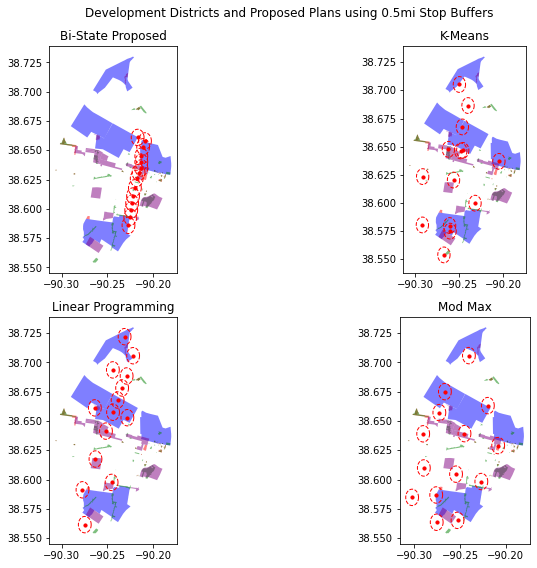

In [43]:
file_paths = [
    "districts/TDD.shp",
    "districts/NRSA.shp",
    "districts/CID.shp",
    "districts/SBD.shp"
]

dists = [gpd.read_file(file, crs='EPSG:4326') for file in file_paths]
colors = ['red', 'blue', 'green', 'purple']
dist_names = ['TDD', 'NRSA', 'CID', 'SBD']  # Assuming you have the plan names defined somewhere
shapefile_paths = [r"plans\OrigStops.shp",r"plans\KMeansStops.shp",r"plans\LPStops.shp",r"plans\MMStops.shp"]
plan_names = ['Bi-State Proposed', 'K-Means','Linear Programming','Mod Max']

lat_deg_to_mi = 69  # Approximation for latitude conversion from degrees to miles
lon_deg_to_mi = 69  
r = 0.007

id = 0
data = []  # List to store data for each district and plan

for id, plan_name in enumerate(plan_names):
    for dist, name in zip(dists, dist_names):
        total_area_deg = dist.area.sum()  
        total_area_mi = total_area_deg * lat_deg_to_mi * lon_deg_to_mi  
        
        stops = gpd.read_file(shapefile_paths[id])
        stops = stops.to_crs("EPSG:4326")
        stops_buffer = stops.buffer(r)  
        stops_buffer_df = gpd.GeoDataFrame(geometry=stops_buffer) 
        
        overlap = gpd.overlay(dist, stops_buffer_df, how='intersection') 
        overlap_area_mi = overlap.area.sum() * lat_deg_to_mi * lon_deg_to_mi 
        
        not_covered_area_mi = total_area_mi - overlap_area_mi  

        
        data.append({'District': name,
                     'Plan Name': plan_name,
                     'Total Area (mi)': total_area_mi,
                     'Overlap Area (mi)': overlap_area_mi,
                     'Uncovered Area (mi)': not_covered_area_mi})

zonalStats_dists = pd.DataFrame(data)
sum_row = pd.Series(zonalStats_dists.sum(numeric_only=True), name='Total')
zonalStats_dists = zonalStats_dists.append(sum_row)
plan_totals = zonalStats_dists.groupby('Plan Name').sum()

######################################################################plot!
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

name = 0
for ax in axs.flat:
    stops = gpd.read_file(shapefile_paths[name])
    stops = stops.to_crs("EPSG:4326")
    col = 0
    for dist in dists:
        dist.plot(ax=ax, color=colors[col], alpha=0.5, label=dist_names[col])
        col += 1

    stops_buffer = stops.buffer(r)
    stops_buffer.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--')
    stops.plot(ax=ax, markersize=10, color='red', marker='o', label='Stops')
    ax.set_title(plan_names[name])
    name += 1

fig.suptitle(f'Development Districts and Proposed Plans using 0.5mi Stop Buffers')
plt.tight_layout()
plt.savefig('outputs\OverlayDists.png')

plt.show()

In [44]:
#plan_totals = plan_totals.drop(columns = 'Total Area (mi)')
plan_totals['Percent Covered Land'] = (plan_totals['Overlap Area (mi)'] / plan_totals['Total Area (mi)']) * 100
plan_totals = plan_totals.drop(columns = ['Total Area (mi)'])
plan_totals.head()
display(zonalStats_dists)

District      Plan Name       Total Area (mi)  Overlap Area (mi)  Uncovered Area (mi)
0        TDD     Bi-State Proposed       0.477             0.022               0.455       
1       NRSA     Bi-State Proposed      17.659             2.574              15.084       
2        CID     Bi-State Proposed       1.675             0.173               1.503       
3        SBD     Bi-State Proposed       4.465             0.943               3.522       
4        TDD               K-Means       0.477             0.003               0.474       
5       NRSA               K-Means      17.659             3.601              14.058       
6        CID               K-Means       1.675             0.286               1.389       
7        SBD               K-Means       4.465             1.091               3.374       
8        TDD    Linear Programming       0.477             0.026               0.451       
9       NRSA    Linear Programming      17.659             3.037              14.621       
10       CID    Linear Programming       1.675             0.062               1.613       
11       SBD    Linear Programming       4.465             1.087               3.379       
12       TDD               Mod Max       0.477             0.076               0.401       
13      NRSA               Mod Max      17.659             1.587              16.072       
14       CID               Mod Max       1.675             0.075               1.601       
15       SBD               Mod Max       4.465             0.683               3.782       
Total    NaN                   NaN      97.106            15.328              81.778

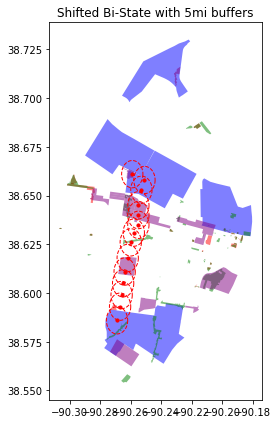

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = r"plans\NudgedOrigStops.shp"
plan_name = 'Nudge'

file_paths = [
    "districts/TDD.shp",
    "districts/NRSA.shp",
    "districts/CID.shp",
    "districts/SBD.shp"
]

dists = [gpd.read_file(file, crs='EPSG:4326') for file in file_paths]
dist_names = ['TDD', 'NRSA', 'CID', 'SBD']

lat_deg_to_mi = 69  # Approximation for latitude conversion from degrees to miles
lon_deg_to_mi = 69  
r = 0.007

id = 0
data = []

# Calculate areas and store data for each district
for dist, name in zip(dists, dist_names):
    total_area_deg = dist.area.sum()  
    total_area_mi = total_area_deg * lat_deg_to_mi * lon_deg_to_mi  
    
    stops = gpd.read_file(shapefile_path)
    stops = stops.to_crs("EPSG:4326")
    stops_buffer = stops.buffer(r)  
    stops_buffer_df = gpd.GeoDataFrame(geometry=stops_buffer) 
    
    overlap = gpd.overlay(dist, stops_buffer_df, how='intersection') 
    overlap_area_mi = overlap.area.sum() * lat_deg_to_mi * lon_deg_to_mi 
    
    not_covered_area_mi = total_area_mi - overlap_area_mi  
    percent_overlap = (overlap_area_mi / total_area_mi) * 100
    
    data.append({'District': name,
                 'Total Area (mi)': total_area_mi,
                 'Overlap Area (mi)': overlap_area_mi,
                 'Uncovered Area (mi)': not_covered_area_mi})

zonalStats_dists_nudge = pd.DataFrame(data)
#sum_row = pd.Series(zonalStats_dists_nudge.sum(numeric_only=True), name='Total')
zonalStats_dists_nudge = zonalStats_dists_nudge.append(sum_row)

######################################################################
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

stops = gpd.read_file(shapefile_path)
stops = stops.to_crs("EPSG:4326")

col = 0
for dist in dists:
    dist.plot(ax=ax, color=colors[col], alpha=0.5, label=dist_names[col])
    col += 1

stops_buffer = stops.buffer(r)
stops_buffer.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--')
stops.plot(ax=ax, markersize=10, color='red', marker='o', label='Stops')

ax.set_title('Shifted Bi-State with 5mi buffers')
plt.tight_layout()
plt.savefig('outputs\OverlayDistsNudge.png')
plt.show()

In [38]:
zonalStats_dists_nudge['Percent Covered Land'] = (zonalStats_dists_nudge['Overlap Area (mi)'] / zonalStats_dists_nudge['Total Area (mi)']) * 100

display(zonalStats_dists_nudge)

District  Total Area (mi)  Overlap Area (mi)  Uncovered Area (mi)  Percent Covered Land
0        TDD         0.477             0.065               0.412                13.596       
1       NRSA        17.659             2.829              14.830                16.018       
2        CID         1.675             0.238               1.437                14.227       
3        SBD         4.465             2.169               2.297                48.567       
Total    NaN        97.106            15.328              81.778                15.784

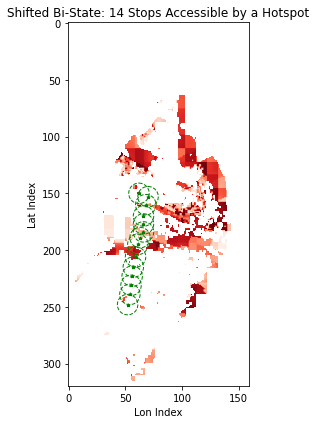

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

shapefile_path = r"plans\NudgedOrigStops.shp"
data = gpd.read_file(shapefile_path)
data = data.to_crs("EPSG:4326")  # Reproject to target CRS
count = 0
collocated_points = []
for idx, row in data.iterrows():
    lon, lat = row.geometry.x, row.geometry.y
    col = int((lon - data_ext_4326[0]) / ((data_ext_4326[2] - data_ext_4326[0]) / n))
    row = int((data_ext_4326[3] - lat) / ((data_ext_4326[3] - data_ext_4326[1]) / m))
    collocated_points.append((col, row))

    # Plotting code
    radius_feet = 5280 // 2  # Example radius in feet, replace with your desired value
    radius_degrees = radius_feet / (approx_km_per_degree_lat * km_to_feet)
    radius_indices = int(radius_degrees * mask.shape[0] / (data_ext_4326[3] - data_ext_4326[1]))
    
    y, x = np.ogrid[-row:m - row, -col:n - col]
    mask_circle = x ** 2 + y ** 2 <= radius_indices ** 2

    # Increment count if any non-NaN value is found within the circular buffer
    if not np.isnan(mask[mask_circle]).all():
        count += 1

    circle = Circle((col, row), radius_indices, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(circle)
ax.scatter([col for col, _ in collocated_points], [row for _, row in collocated_points],
                                marker='*', color='green', s=10)

# Plot other elements as needed
img = ax.imshow(mask, cmap='Reds')
ax.set_title(f"Shifted Bi-State: {count} Stops Accessible by a Hotspot")
ax.set_xlabel('Lon Index')
ax.set_ylabel('Lat Index')

#fig.suptitle('Transit Need Hotspots Overlay with Nudged Plan Plan using a 0.5mi Buffer')
plt.tight_layout()

plt.savefig('outputs\OverlaySVRNudge.png')
plt.show()